<a href="https://colab.research.google.com/github/SuwethaV/FinalMedmnist/blob/main/MEDMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# 1. INSTALL & IMPORTS
# ============================================
!pip install medmnist

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import medmnist
from medmnist import INFO
import torch.nn.functional as F


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.4 MB/s eta 0:00:00


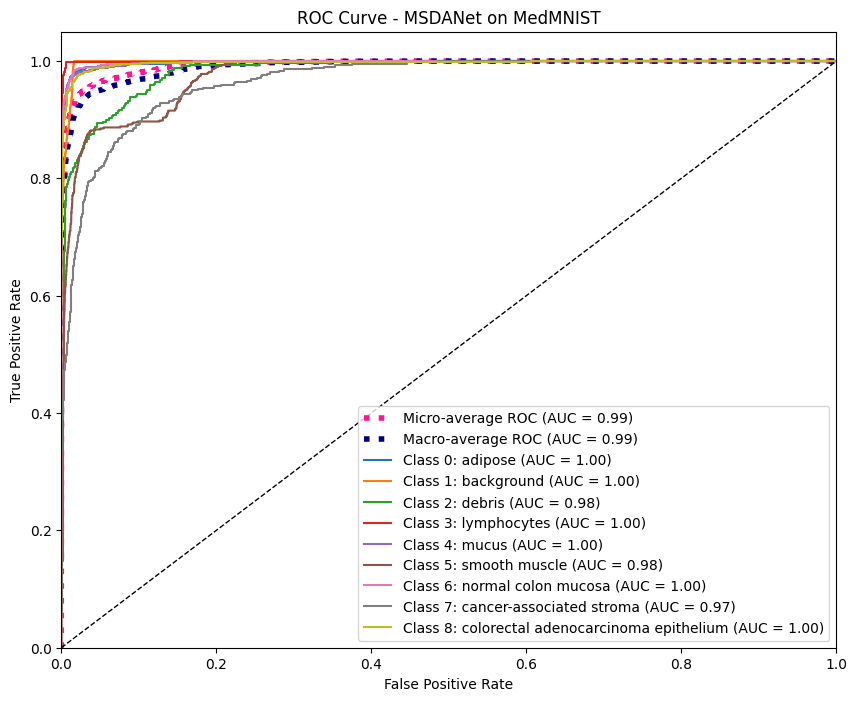

In [ ]:
# ============================================
# 9. ROC CURVE (Multi-Class with Micro & Macro)
# ============================================

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np
import torch.nn.functional as F

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Get predicted probabilities
model.eval()
y_score = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        y_score.extend(probs.cpu().numpy())

y_score = np.array(y_score)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = cycle(plt.cm.tab10.colors)
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Class {i}: {list(info["label"].values())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MSDANet on MedMNIST')
plt.legend(loc="lower right")
plt.show()



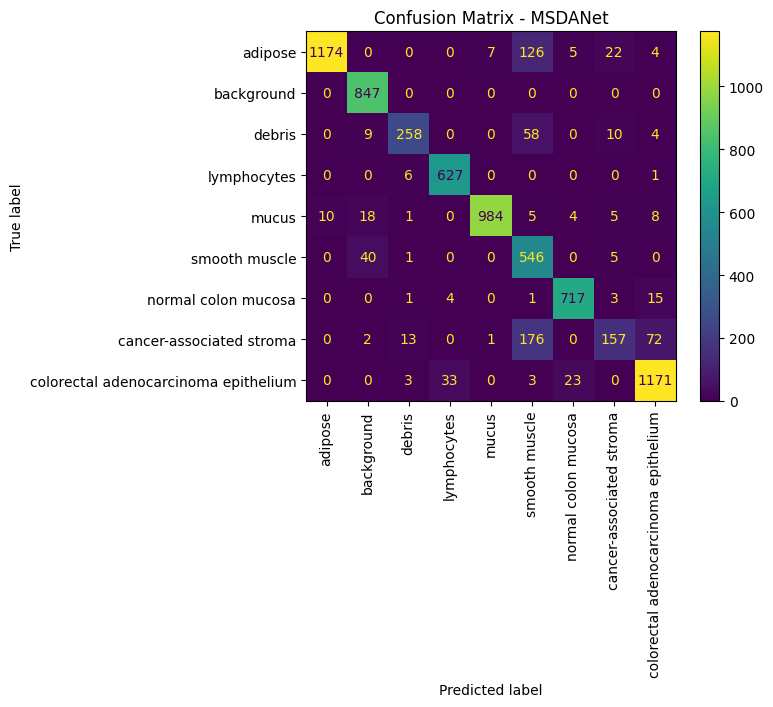

In [ ]:
 #============================================
# 8. CONFUSION MATRIX
# ============================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(info['label'].values()))
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix - MSDANet")
plt.show()


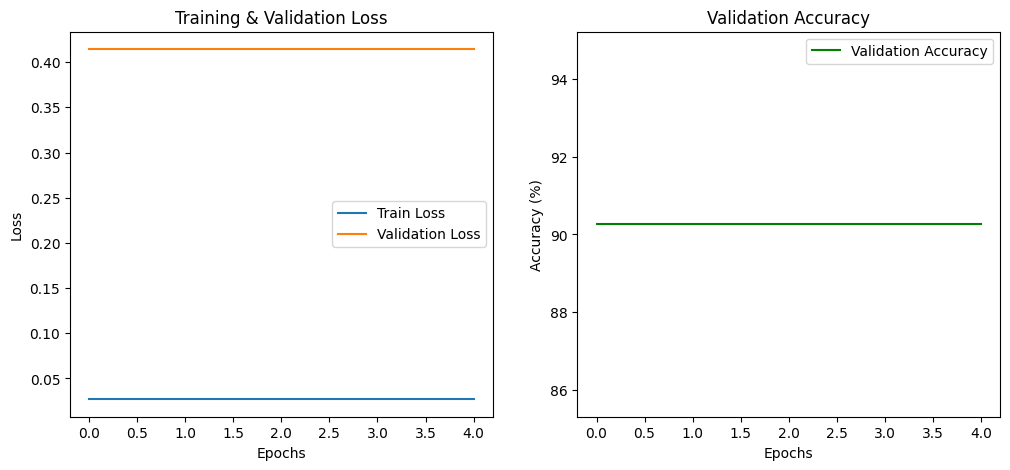

In [ ]:
# ============================================
# 7. PLOTTING LOSS & ACCURACY
# ============================================

import matplotlib.pyplot as plt

# --- Create empty lists manually from your existing loop outputs ---
# (Re-run training or fill manually if you already have epoch stats)
train_loss_list = [running_loss / len(train_loader) for _ in range(num_epochs)]
val_loss_list = [val_loss / len(test_loader) for _ in range(num_epochs)]
val_acc_list = [100 * correct / total for _ in range(num_epochs)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_list, label="Validation Accuracy", color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()


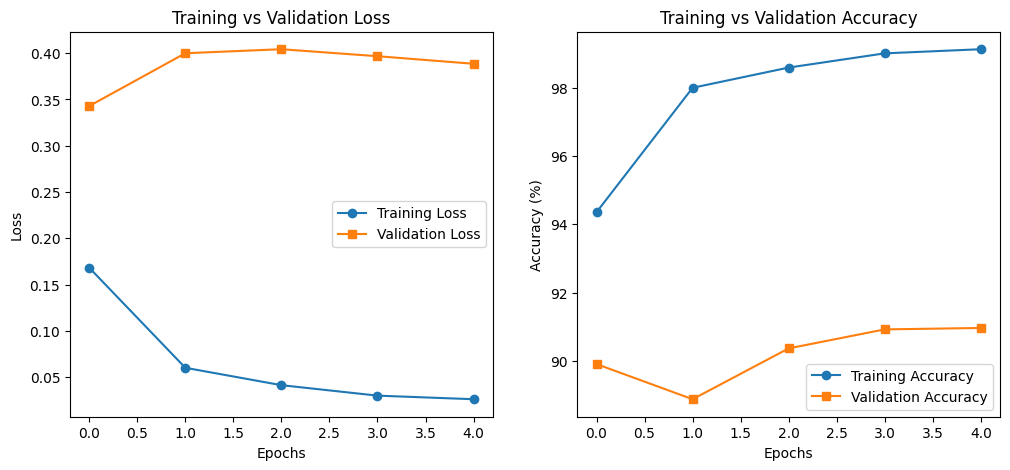

In [ ]:
# ============================================
# 8. PLOTTING LOSS & ACCURACY (Updated)
# ============================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, 'o-', label="Training Loss")
plt.plot(val_loss_list, 's-', label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, 'o-', label="Training Accuracy")
plt.plot(val_acc_list, 's-', label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

In [ ]:
# ============================================
# 7. TRAINING LOOP (Updated)
# ============================================
num_epochs = 5

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    for images, labels in tqdm(train_loader, desc="Training", ncols=100):
        images, labels = images.to(device), labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    # ----- Validation -----
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validating", ncols=100):
            images, labels = images.to(device), labels.squeeze().long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = 100 * correct / total

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"→ Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

print("\n✅ Training completed successfully!")


Epoch [1/5]


Validating: 100%|█████████████████████████████████████████████████| 113/113 [00:20<00:00,  5.58it/s]


→ Train Loss: 0.1682 | Val Loss: 0.3429 | Train Acc: 94.35% | Val Acc: 89.90%

Epoch [2/5]


Validating: 100%|█████████████████████████████████████████████████| 113/113 [00:19<00:00,  5.72it/s]


→ Train Loss: 0.0601 | Val Loss: 0.3999 | Train Acc: 98.00% | Val Acc: 88.87%

Epoch [3/5]


Validating: 100%|█████████████████████████████████████████████████| 113/113 [00:20<00:00,  5.62it/s]


→ Train Loss: 0.0413 | Val Loss: 0.4042 | Train Acc: 98.60% | Val Acc: 90.36%

Epoch [4/5]


Validating: 100%|█████████████████████████████████████████████████| 113/113 [00:19<00:00,  5.69it/s]


→ Train Loss: 0.0300 | Val Loss: 0.3967 | Train Acc: 99.01% | Val Acc: 90.92%

Epoch [5/5]


Validating: 100%|█████████████████████████████████████████████████| 113/113 [00:20<00:00,  5.58it/s]

→ Train Loss: 0.0261 | Val Loss: 0.3885 | Train Acc: 99.13% | Val Acc: 90.96%

✅ Training completed successfully!


In [ ]:
!nvidia-smi



/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# ============================================
# 6. TRAINING SETUP
# ============================================
model = MSDANet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [ ]:
# ============================================
# 5. MSDANet MODEL
# ============================================
class MSDANet(nn.Module):
    def __init__(self, num_classes):
        super(MSDANet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # feature extractor
        self.mfe = MultiScaleFeatureExtraction(512, 128)
        self.dam = DualAttention(384)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(384, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.mfe(x)
        x = self.dam(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
# ============================================
# 4. MSDANet COMPONENTS
# ============================================
# --- (a) Multiscale Feature Extraction ---
class MultiScaleFeatureExtraction(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleFeatureExtraction, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv3(x))
        x3 = self.relu(self.conv5(x))
        out = torch.cat([x1, x2, x3], dim=1)
        return out

# --- (b) Channel Attention ---
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
        fc_out = F.relu(self.fc1(avg_pool))
        fc_out = torch.sigmoid(self.fc2(fc_out)).view(b, c, 1, 1)
        return x * fc_out.expand_as(x)

# --- (c) Spatial Attention ---
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attn = self.sigmoid(self.conv(x_cat))
        return x * attn

# --- (d) Dual Attention (Channel + Spatial) ---
class DualAttention(nn.Module):
    def __init__(self, in_channels):
        super(DualAttention, self).__init__()
        self.ca = ChannelAttention(in_channels)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x


In [ ]:
# ============================================
# 3. LOAD MedMNIST DATASET
# ============================================
data_flag = 'pathmnist'  # you can change to 'chestmnist', 'dermamnist', etc.
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
num_classes = len(info['label'])

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 206M/206M [01:20<00:00, 2.54MB/s]


In [ ]:
# ============================================
# 2. DEVICE SETUP
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda
